# Text Summarization Project

<u>Notes</u>
* Dataset: https://huggingface.co/datasets/har1/MTS_Dialogue-Clinical_Note
* Fine-tuning model: bart-base
* NLI model: https://huggingface.co/FacebookAI/roberta-large-mnli
* Teacher forcing is automatically applied during training
* During inference, you should consider beam search and temperature

<u>Action Items</u>

* <s>Apply a fine-tuned text summarization model to the dataset and see what comes out (done)</s>
* <s>Apply bart-base to the dataset and see what comes out (done)</s>
* <s>Preprocessing - do you want to skip any samples? Also, I don't think they flagged training vs. validation, so you may want to do the splits yourself. Do you want to ignore classes with low representation?</s>
* You should understand the APIs for common huggingface classes (Trainer, TrainingArguments) - this is mostly done
* Seq2SeqTrainingArguments
    * generation max len = 500 (349 is max output seq len in dataset)
    * generation num beams = 4 (seems like everyone's default)
    * do_sample - False to start?
    * temperature, top_k - read about this
    * earlystopping = True - how do I pass this?
    * **custom generation config?**
* Start with training and inferring on the same samples as a sanity check (already did for 1 sample). Then gradually increase the number of samples and adjust hyperparameters as needed.
* In huggingface, teacher forcing is applied 100% of the time by default (confirm this in the documentation)
* **Mixed precision or lower precision training for efficiency**
* You should understand how BART is pretrained. You should understand the "checkpoint" you are loading with bart-base. You should understand BART-base and BART-large.
    * **Should you unfreeze the final dense layer of the decoder? Well, on 1 sample, with LoRA, you were able to get perfect performance**
* <s>Understand LoRA arguments</s>
* **BERTScore IDF dict**
* Are there any good regularization or generalization techniques?
    * Label smoothing?
    * Data augmentation? - use SOTA LLM to enrich the dataset
    * Dropout, weight decay (L1/L2)
    * Early stopping
* <s>Is evaluation really slow with valmet? I think it was, but can you confirm? Yes - interestingly, it's very slow even if I use only BERT or only ROUGE</s>
* Testing
    * <s>har1 did not convert the test set labels to the new format, so there's no test set. I don't think it's feasible to manually do this myself - there are 400 test samples.</s>
    * <s>I ran predictions on 10 samples from training dataset and 10 samples from validation dataset. I'm on the right track, but I think performance is not as good as har1.</s>
    * <s>Resplit into train/val/test</s>
    * As a last step, you could try running on the actual test data without labels and do some manual checking
* Check the "MEDIQA" challenges
    * Task A is both summarization and classification - you're supposed to predict the section header as well. You can still do this I think. Use the encoder output.
    * I think I should do just summarization first.
* You got access to PhysioNet

<u>Hyperparameter tuning</u>
* **You should pay more attention to grad_norm - it's better than loss for evaluating convergence**
* Unfreezing the lm_head is definitely needed; the model cannot learn this domain-specific knowledge with LoRA alone.
    * You could try applying LoRA to lm_head.
    * For educational purposes, try disabling LoRA and unfreezing the lm_head.
    * With this change, the model is now overfitting. You will need to add regularization to the base BART model.
    * **Even with overfitting, the training predictions are not good. Do you need to unfreeze more layers? Do you need to increase LoRA r/alpha?**
        * **Try increasing r, then alpha**
        * **Try unfreezing all layers**
        * **Loss needs to be around 0.4, preferably 0.1 to 0.2**
    * **Try a larger model**
* **Right now, I think the order should be learning rate, grad accum, lr scheduler. Then LoRA rank, alpha**
* If I increase grad accum, then I'm basically taking bigger steps. Does this help? No, convergence and steady-state are worst.
* If I decrease grad accum, then I'm taking smaller steps. Does this help?
* Learning rate, lr scheduler, warmup, AdamW params?, batch size, grad accum
* LoRA - rank, alpha, dropout
* Mixed/lower precision training
* **model.generate() - let's train the model, with unfrozen lm_head, with default regularization for 30 epochs. Save the model checkpoints every 10 epochs. Then check inference on training and validation test sets. See what kind of decoding strategy you should use, or if it even helps.**
* <s>Still not generalizing despite many experiments - take another look at the dataset. Use the actual validation samples for validation. Same trend here.</s>

<u>Ayman's Suggestions</u>
* Investigating the dataset
    * <s>5-fold cross validation</s>
    * Visualize the samples with sentence-transformers and t-SNE: https://huggingface.co/sentence-transformers
    * **Try training with another model - flan t5**
* Compare other small models like flan-t5, gpt-2
* Try packing the samples for efficiency - this is taking too long to figure out. You will probably need to use SFTTrainer. Figure this out later.
    * DataCollatorWithFlattening: https://research.ibm.com/blog/hugging-face-training-flash-attention
    * SFTTrainer
* <s>push_to_hub saves the final model state, I think (including if you load best model). Check out wandb.</s>
* <s>unsloth - quantization, fine-tuning, pruning</s>

<u>Questions</u>
* When I apply LoRA, I don't need any special handling for generation. But when I don't, I need to pass a GenerationConfig object and specify bos_token_id, decoder_start_token_id
* Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config.
* Saving/loading models, with and without adapters
    * What's the difference b/w PeftModel.from_pretrained(base_model, adapter_path) and base_model.load_adapter(adapter_path)?

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install peft
# !pip install bert-score
# !pip install rouge-score

In [25]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, AutoConfig, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from transformers import EarlyStoppingCallback, GenerationConfig, TrainerCallback, BartForConditionalGeneration, BartConfig, GenerationConfig
# from trl import SFTTrainer
import datasets
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model, PeftModel, PeftConfig
import evaluate
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import os
import gc
import json

In [2]:
# torch.cuda.is_available = lambda : False
# torch.cuda.is_available()

# Get dataset and tokenize

In [2]:
model_name = 'facebook/bart-base'
# model_name = 'facebook/bart-large-cnn'

tokenizer = AutoTokenizer.from_pretrained(model_name, truncation_side='left') # the beginning of the dialogue usually contains less information (hi, how are you?) so truncate from the left
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# print(f'pad_token_id: {tokenizer.pad_token_id}')
# print(f'bos_token_id: {tokenizer.bos_token_id}')
# print(f'eos_token_id: {tokenizer.eos_token_id}')
# dir(tokenizer)

In [4]:
ds = load_dataset('ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit', streaming=False)
# ds = load_dataset('ryanwtsai/MTS_Dialogue-Clinical_Note_OriginalTrainValSplit', streaming=False)
# ds = load_dataset('ryanwtsai/MTS_Dialogue-Clinical_Note_Kfold4', streaming=False)
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 128
    })
})

In [5]:
# Subset if desired

# ds['train'] = ds['train'].shuffle(seed=42).select(range(100))
# ds['train'] = ds['train'].select(range(109,ds['train'].num_rows))
# ds['val'] = ds['train'].shuffle(seed=42).select(range(12))
# ds

In [6]:
# Class to handle tokenization and dataloading

class TextPreprocessor:
    def __init__(self, tokenizer, model, dataset, input_col, output_col=None, padding=False, truncation=True, batch_size=8):
        """
        Initialize the class with a tokenizer, model, dataset, and various tokenization options.
        - dataset - currently assumes this is a dataset dictionary with keys 'train', 'val', 'test'
        - input_col: The column name for the input sequences.
        - output_col: The column name for the output sequences (if applicable). If None, assume single sequence input.
        - padding: Padding strategy (e.g., "max_length", "longest", or a specific integer length).
        - truncation: Truncation strategy (boolean or "longest_first").
        """
        self.tokenizer = tokenizer
        # self.model = model
        self.model_max_length = model.config.max_position_embeddings
        self.dataset = dataset
        self.input_col = input_col
        self.output_col = output_col
        self.padding = padding
        self.truncation = truncation
        self.batch_size = batch_size
        self.tokenized_dataset = {}
        self.truncation_tracker = {}
        self.dataloader = {}

    def tokenize_function(self, examples):
        # Tokenize a pair of sequences (input-output pair, e.g. for summarization)
        if self.output_col:
            tokenized = self.tokenizer(
                examples[self.input_col],
                text_target=examples[self.output_col],   # target sequence
                padding=self.padding,
                truncation=self.truncation,
                max_length=self.model_max_length,
                return_tensors='np',
                return_length=True,
                # return_overflowing_tokens=True
            )

        # Tokenize a single sequence
        else:
            tokenized = self.tokenizer(
                examples[self.input_col],
                padding=self.padding,
                truncation=self.truncation,
                max_length=self.model_max_length,
                return_tensors='np',
                return_length=True,
                # return_overflowing_tokens=True
            )

        # tokenized = dictionary
        # keys = input_ids, attention_mask, labels
        # size = batch size, sequence length (input_ids and attention_mask have the same length)

        # Check for truncation
        if self.truncation not in [False, 'do_not_truncate']:
            # Get non-truncated lengths
            input_lens = self.tokenizer(examples[self.input_col], truncation=False, return_tensors='np', return_length=True)['length']
            # print(type(input_lens))
            # print(input_lens.shape)
            # print(input_lens[:10])

            # Calculate how many tokens were truncated
            trunc_lens = np.clip(input_lens - tokenized['length'], a_min=0, a_max=None)
            trunc_lens_indexing = np.nonzero(trunc_lens > 0)[0]
            # print(type(trunc_lens))
            # print(trunc_lens.shape)
            # print(trunc_lens_indexing[:10])

            # Get IDs for non-zero truncations
            # print(type(examples['ID']))
            # trunc_ids = examples['ID'][trunc_lens_indexing]
            trunc_ids = [examples['ID'][i] for i in trunc_lens_indexing]
            trunc_lens = trunc_lens[trunc_lens > 0].tolist()

            self.truncation_tracker.update(dict(zip(trunc_ids, trunc_lens)))

        return tokenized

    def tokenize_dataset(self):
        """Applies tokenization to the dataset using the tokenize_function."""

        self.tokenized_dataset = self.dataset.map(self.tokenize_function, batched=True)
        # self.tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

        # for key in self.dataset:
        #     print(f'Tokenizing {key} split...')
        #     self.tokenized_dataset[key] = self.dataset[key].map(self.tokenize_function, batched=True)
        #     self.tokenized_dataset[key].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # def create_dataloader(self, shuffle_train=True):
    #     """Creates a DataLoader from the tokenized dataset."""
    #     if self.tokenized_dataset == {}:
    #         raise ValueError("Tokenized dataset is not available. Run tokenize_dataset() first.")

    #     # Convert to PyTorch DataLoader for batching
    #     for key in self.tokenized_dataset:
    #         shuffle = shuffle_train if key == 'train' else False
    #         print(f'Creating {key} dataloader...')
    #         self.dataloader[key] = DataLoader(self.tokenized_dataset[key], batch_size=self.batch_size, shuffle=shuffle)

    # def get_dataloader(self):
    #     """Returns the DataLoader, creating it if necessary."""
    #     if self.dataloader == {}:
    #         self.create_dataloader()
    #     return self.dataloader

In [7]:
preprocessor = TextPreprocessor(tokenizer, model, ds, 'dialogue', output_col='section_text')

preprocessor.tokenize_dataset()

In [8]:
preprocessor.truncation_tracker
del model
gc.collect()

85

# Define validation metrics

In [9]:
bertscore = evaluate.load('bertscore')
rouge = evaluate.load('rouge')
print(bertscore.__class__.__name__)
print(rouge.__class__.__name__)

BERTScore
Rouge


In [10]:
class ValidationMetrics:
    def __init__(self, tokenizer, *metrics):
        self.tokenizer = tokenizer
        self.metrics = metrics

    def compute_metrics(self, evalpred):
        predictions = np.copy(evalpred.predictions)
        labels = np.copy(evalpred.label_ids)
        # print(f'Unique predictions: {sorted(set(predictions.flatten()))}')
        # print(f'Unique labels: {sorted(set(labels.flatten()))}')

        # Replace -100 (padding used to ignore token in loss computation) with pad_token_id
        # Otherwise tokenizer.batch_decode throws an error
        predictions[predictions == -100] = self.tokenizer.pad_token_id
        labels[labels == -100] = self.tokenizer.pad_token_id
        # print(f'Unique predictions (after): {sorted(set(predictions.flatten()))}')
        # print(f'Unique labels (after): {sorted(set(labels.flatten()))}')

        decoded_preds = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        results = {}
        for metric in self.metrics:
            if metric.__class__.__name__ == "BERTScore":
                result = metric.compute(predictions=decoded_preds, references=decoded_labels, model_type='distilbert-base-uncased')
                result.pop('hashcode')
                result = {f'eval_bertscore_{k}': np.mean(np.array(v)) for k, v in result.items()}
            elif metric.__class__.__name__ == "Rouge":
                result = metric.compute(predictions=decoded_preds, references=decoded_labels)
                results = {f'eval_{k}': v for k, v in results.items()}

            results.update(result)

        return results

valmet = ValidationMetrics(tokenizer, bertscore, rouge)

print("Initialized ValidationMetrics object")

Initialized ValidationMetrics object


# Training

In [11]:
# Training hyperparameters

fname = "bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_wd-4"
resume_from_checkpoint = False
checkpoint_path = r"output\bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_drop-0.2-0.2-0.2\checkpoint-1950"

logging_dir = './logs/'
logname = logging_dir + fname + '.txt'
output_dir = './output/' + fname

unfreeze_layers = 'lm-head'
# unfreeze_layers = 'all' # 'lm' for lm-head, 'all' for all. Disables PEFT (PEFT is enabled by default)
# unfreeze_layers = False

num_epochs = 15
# learning_rate = 1.6e-3
learning_rate = 4e-4
# learning_rate = 8e-4
# gamma = 0.9994 # for StepLR
gamma = 0.998
# gamma = 0.997
patience = 10 # for early stopping
patience = False

train_batch_size = 2
eval_batch_size = 2
grad_accum = 4

# LoRA
apply_lora = False
r = 512 # default 8
lora_alpha = 512 # default 32
lora_dropout = 0

# BART
dropout = 0.1 # applied after linear transformation in ffnn in encoder/decoder. default = 0.1.
attention_dropout = 0.1 # attention layers in encoder/decoder. default = 0.1.
activation_dropout = 0.1 # applied after activations in ffnn in encoder/decoder. default = 0.1.

# Regularization
weight_decay = 4 # default = 0

In [10]:
if apply_lora:
    peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
else:
    peft_config = None

model_config = AutoConfig.from_pretrained(model_name,
                                    dropout=dropout,
                                    attention_dropout=attention_dropout,
                                    activation_dropout=activation_dropout)

class ModelInitializer():
    def __init__(self, model_name, unfreeze_layers=False, model_cfg=None, peft_cfg=None, resume_from_checkpoint=False, checkpoint_path=""):
        self.model_name = model_name
        self.unfreeze_layers = unfreeze_layers
        self.model_cfg = model_cfg
        self.peft_cfg = peft_cfg
    
    def model_init(self):
        print("Initializing model...")

        if not resume_from_checkpoint: # fresh model
            print("Initializing fresh model.")
            
            # Get base model
            print(f"Loading base model {self.model_name}")
            if self.model_cfg is not None:
                model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name, config=self.model_cfg)
            else:
                model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name)
                
            if self.unfreeze_layers == 'all':
                print("Unfreezing all layers in the base model.")
                for name, module in model.named_modules():
                    if hasattr(module, "weight"):
                        print(f"Unfreezing {name}")
                        module.weight.requires_grad = True
            else:
                # Apply PEFT
                if self.peft_cfg is not None:
                    print("Applying PEFT.")
                    model = get_peft_model(model, self.peft_cfg)
        
                if self.unfreeze_layers == 'lm-head':
                    for name, module in model.named_modules():
                        if "lm_head" in name: # unfreeze lm_head
                            print(f"Unfreezing {name}.")
                            module.weight.requires_grad = True
    
            # print("Full list of unfrozen weights:")
            # for name, module in model.named_modules():
            #     if hasattr(module, "weight") and module.weight.requires_grad:
            #         print(name)

        else: # resume from checkpoint. Currently only supports (1) loading base model from huggingface and adapter weights from disk (2) loading base model from disk
            print("Loading model from checkpoint.")
            
            if self.peft_cfg is not None:
                # Get base model
                print(f"Loading base model {self.model_name}.")
                if self.model_cfg is not None:
                    model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name, config=self.model_cfg)
                else:
                    model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name)

                print(f"Loading adapter weights from {checkpoint_path}.")
                model = PeftModel.from_pretrained(model, checkpoint_path, config=self.peft_cfg, is_trainable=True)
            else:
                print(f"Loading base model weights from {checkpoint_path}.")
                if self.model_cfg is not None:
                    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path, config=self.model_cfg)
                else:
                    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path)

        if hasattr(model, "print_trainable_parameters"):
            model.print_trainable_parameters()

        print("Model initialized.")
        return model

modelinit = ModelInitializer(model_name, unfreeze_layers=unfreeze_layers, model_cfg=model_config, peft_cfg=peft_config, resume_from_checkpoint=resume_from_checkpoint, checkpoint_path=checkpoint_path)

print("ModelInitializer class initialized")

ModelInitializer class initialized


In [9]:
# model = modelinit.model_init()
# model.config

In [10]:
# model.base_model.model.model.shared
# model.base_model.model.model.encoder.embed_tokens
# model.base_model.model.model.decoder.embed_tokens

In [11]:
# for name, module in model.named_modules():
#     # print(name)
#     if hasattr(module, "weight") and module.weight.requires_grad:
#         print(name)
# del model

In [11]:
# output_dir = './output/' + savemodel

ds_train = preprocessor.tokenized_dataset['train']
ds_eval = preprocessor.tokenized_dataset['val']

# To debug samples
# class PrintIDCallback(TrainerCallback):
#     def on_train_batch_start(self, args, state, control, **kwargs):
#         # Extract the batch's ID from the input data
#         if 'inputs' in kwargs:
#             inputs = kwargs['inputs']  # The inputs from the trainer
#             ids = [feature['ID'] for feature in inputs]
#             print(f"Processing IDs: {ids}", flush=True)

if patience is not False:
    callbacks = [EarlyStoppingCallback(early_stopping_patience=patience)]
else:
    callbacks = []

model = modelinit.model_init()

gen_cfg = GenerationConfig(
    max_length=500,
    decoder_start_token_id=model.config.decoder_start_token_id,
    bos_token_id=model.config.bos_token_id,
    eos_token_id=model.config.eos_token_id,
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

if not resume_from_checkpoint:
    print("Fresh training.")
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    lr_scheduler = StepLR(optimizer, 1, gamma=gamma)
    # gen_cfg = GenerationConfig(max_length=500)
    
    training_args = Seq2SeqTrainingArguments(
        disable_tqdm=True,  # disable progress bar
        output_dir=output_dir,
        # save_strategy='no',
        # save_strategy='epoch', # save model checkpoints at the end of each epoch
        save_strategy='steps',
        save_steps=math.floor(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/(3*num_epochs/15)),
        save_total_limit=1, # only save the last N checkpoints
        eval_strategy='epoch',  # run validation at the end of each epoch
        # eval_strategy='no',
        # eval_strategy='steps',
        # eval_steps=math.ceil(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/10),
    
        # load_best_model_at_end=True,  # load the best model found during training
        # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
        # metric_for_best_model='accuracy', # this needs to match a key in the returned dictionary from compute_metrics()
        # greater_is_better=False, # higher value for metric_for_best_model is better
    
        # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
        logging_dir=logging_dir,
        # logging_strategy='no',
        # logging_strategy='epoch',
        logging_strategy='steps',
        # logging_steps=num_epochs/100,
        logging_steps=math.ceil(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/(100*num_epochs/15)),
    
        per_device_train_batch_size=train_batch_size, # batch size per device (CPU core/GPU/etc.)
        per_device_eval_batch_size=eval_batch_size, # batch size per device (CPU core/GPU/etc.)
    
        # Training hyperparameters
        num_train_epochs=num_epochs, # max epochs
        gradient_accumulation_steps=grad_accum,
        # learning_rate=5e-8, # default is 5e-5
        # learning_rate=3e-5, # FYI: the default linear scheduler updates learning rate per batch
        learning_rate=learning_rate,
        # warmup_ratio=0.2, # 20% of training steps
        # max_grad_norm=1.0,
        weight_decay=weight_decay,
    
        # Seq2Seq
        predict_with_generate=True,
        # generation_max_length=500,
        #generation_num_beams=4,
        generation_config=gen_cfg,
    
        # Random
        seed=42,
    )
    
    trainer = Seq2SeqTrainer(
        model=model,
        # model_init=modelinit.model_init,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        optimizers=(optimizer, lr_scheduler),
        tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
        data_collator=data_collator, # dynamic padding
        callbacks=callbacks,
        # compute_metrics=valmet.compute_metrics,
    )
else:
    print("Resume training from checkpoint.")

    optimizer = AdamW(model.parameters())
    optimizer.load_state_dict(torch.load(checkpoint_path + r'\optimizer.pt'))
    lr_scheduler = StepLR(optimizer, 1)
    lr_scheduler.load_state_dict(torch.load(checkpoint_path + r'\scheduler.pt'))

    training_args = Seq2SeqTrainingArguments(
        disable_tqdm=True,  # disable progress bar
        output_dir=output_dir,
        # save_strategy='no',
        # save_strategy='epoch', # save model checkpoints at the end of each epoch
        save_strategy='steps',
        save_steps=math.floor(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/(3*num_epochs/15)),
        # save_total_limit=2, # only save the last N checkpoints
        eval_strategy='epoch',  # run validation at the end of each epoch
        # eval_strategy='no',
        # eval_strategy='steps',
        # eval_steps=math.ceil(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/10),
    
        # load_best_model_at_end=True,  # load the best model found during training
        # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
        # metric_for_best_model='accuracy', # this needs to match a key in the returned dictionary from compute_metrics()
        # greater_is_better=False, # higher value for metric_for_best_model is better
    
        # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
        logging_dir=logging_dir,
        # logging_strategy='no',
        # logging_strategy='epoch',
        logging_strategy='steps',
        # logging_steps=num_epochs/100,
        logging_steps=math.ceil(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/(100*num_epochs/15)),
    
        per_device_train_batch_size=train_batch_size, # batch size per device (CPU core/GPU/etc.)
        per_device_eval_batch_size=eval_batch_size, # batch size per device (CPU core/GPU/etc.)
    
        # Training hyperparameters
        num_train_epochs=num_epochs, # max epochs
        gradient_accumulation_steps=grad_accum,
        # learning_rate=5e-8, # default is 5e-5
        # learning_rate=3e-5, # FYI: the default linear scheduler updates learning rate per batch
        # learning_rate=learning_rate,
        # warmup_ratio=0.2, # 20% of training steps
        # max_grad_norm=1.0,
        # weight_decay=weight_decay,
    
        # Seq2Seq
        predict_with_generate=True,
        # generation_max_length=500,
        #generation_num_beams=4,
        generation_config=gen_cfg,
    
        # Random
        # seed=42,
    )
    
    trainer = Seq2SeqTrainer(
        model=model,
        # model_init=modelinit.model_init,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        optimizers=(optimizer, lr_scheduler),
        tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
        data_collator=data_collator, # dynamic padding
        callbacks=callbacks,
        # compute_metrics=valmet.compute_metrics,
    )

print("Finished setting up Trainer and TrainingArguments")

Initializing model...
Initializing fresh model.
Loading base model facebook/bart-base
Unfreezing lm_head.
Model initialized.
Fresh training.
Finished setting up Trainer and TrainingArguments


In [12]:
print(f"Logs will be saved in {logname}")
print(f"Model state will be saved in {output_dir}")
print("****************************************************************")

print(f"Number of training epochs = {trainer.args.num_train_epochs}")
print(f"Effective batch size = {trainer.args.per_device_train_batch_size*trainer.args.gradient_accumulation_steps}")
# print(f"Learning rate = {trainer.args.learning_rate}")
# print(f"Weight decay = {trainer.args.weight_decay}")
if True:
    print(f"AdamW(lr={trainer.optimizer.param_groups[0]['lr']}, weight_decay={trainer.optimizer.param_groups[0]['weight_decay']})")
    print(f"StepLR(step_size={trainer.lr_scheduler.step_size}, gamma={trainer.lr_scheduler.gamma})")
else:
    print("Optimizer and LR scheduler will be loaded from checkpoint")

for callback in trainer.callback_handler.callbacks:
    if callback.__class__.__name__ == 'EarlyStoppingCallback':
        print(f"Early stopping patience = {callback.early_stopping_patience}")
print('')

if hasattr(trainer.model, "peft_config"):
    print(f"LoRA r = {trainer.model.peft_config['default'].r}")
    print(f"LoRA alpha = {trainer.model.peft_config['default'].lora_alpha}")
    print(f"LoRA dropout = {trainer.model.peft_config['default'].lora_dropout}")
    print('')

print(f"BART dropout = {trainer.model.config.dropout}")
print(f"BART activation dropout = {trainer.model.config.activation_dropout}")
print(f"BART attention dropout = {trainer.model.config.attention_dropout}")
print('')

print(f"Generation max len = {trainer.args.generation_config.max_length}")
print(f"Generation num beams = {trainer.args.generation_config.num_beams}")
print('')

Logs will be saved in ./logs/bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_wd-4.txt
Model state will be saved in ./output/bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_wd-4
****************************************************************
Number of training epochs = 15
Effective batch size = 8
AdamW(lr=0.0004, weight_decay=4)
StepLR(step_size=1, gamma=0.998)

BART dropout = 0.1
BART activation dropout = 0.1
BART attention dropout = 0.1

Generation max len = 500
Generation num beams = 1



In [13]:
print('GPU available') if torch.cuda.is_available() else print('No GPU')
print(f'Trainer is using {trainer.args.device}')

GPU available
Trainer is using cuda:0


In [14]:
%%capture captured_output

if not resume_from_checkpoint:
    trainer.train()
else:
    trainer.train(resume_from_checkpoint=checkpoint_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

In [15]:
print(captured_output.stdout)

with open(logname, "w") as file:
    file.write(captured_output.stdout)
    print(f"File saved: {logname}")



{'loss': 3.7419, 'grad_norm': 5.952205181121826, 'learning_rate': 0.0003843003828105371, 'epoch': 0.15384615384615385}
{'loss': 2.3525, 'grad_norm': 5.067540645599365, 'learning_rate': 0.00036921696057081333, 'epoch': 0.3076923076923077}
{'loss': 1.977, 'grad_norm': 4.242722034454346, 'learning_rate': 0.00035472554821876635, 'epoch': 0.46153846153846156}
{'loss': 1.8457, 'grad_norm': 2.963433027267456, 'learning_rate': 0.00034080290993287386, 'epoch': 0.6153846153846154}
{'loss': 1.8275, 'grad_norm': 3.166356325149536, 'learning_rate': 0.000327426721875371, 'epoch': 0.7692307692307693}
{'loss': 1.8599, 'grad_norm': 3.6657819747924805, 'learning_rate': 0.00031457553639776083, 'epoch': 0.9230769230769231}
{'eval_loss': 1.5907936096191406, 'eval_runtime': 3.4344, 'eval_samples_per_second': 38.435, 'eval_steps_per_second': 19.217, 'epoch': 1.0}
{'loss': 1.5586, 'grad_norm': 4.8123860359191895, 'learning_rate': 0.0003022287476512238, 'epoch': 1.0769230769230769}
{'loss': 1.4409, 'grad_norm'

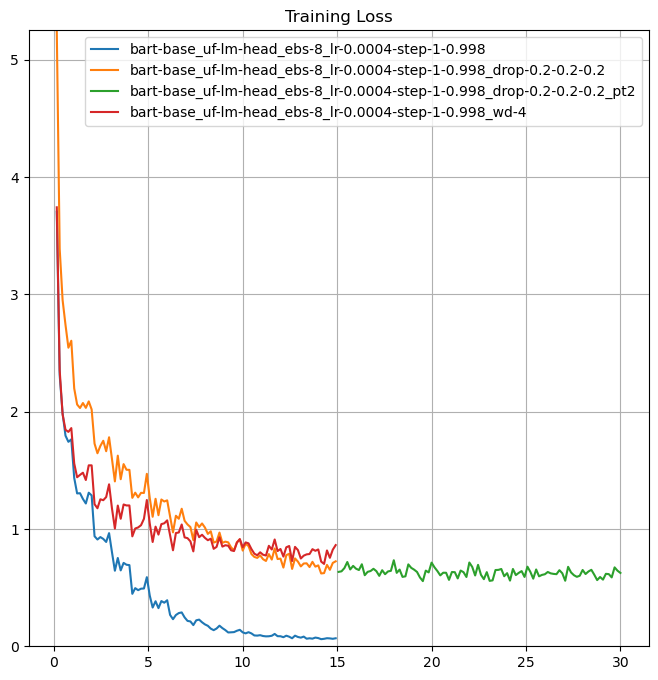

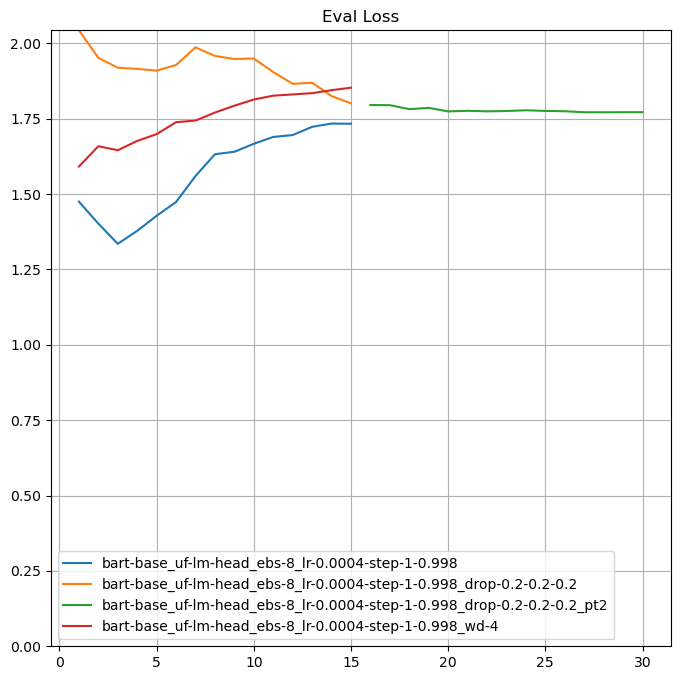

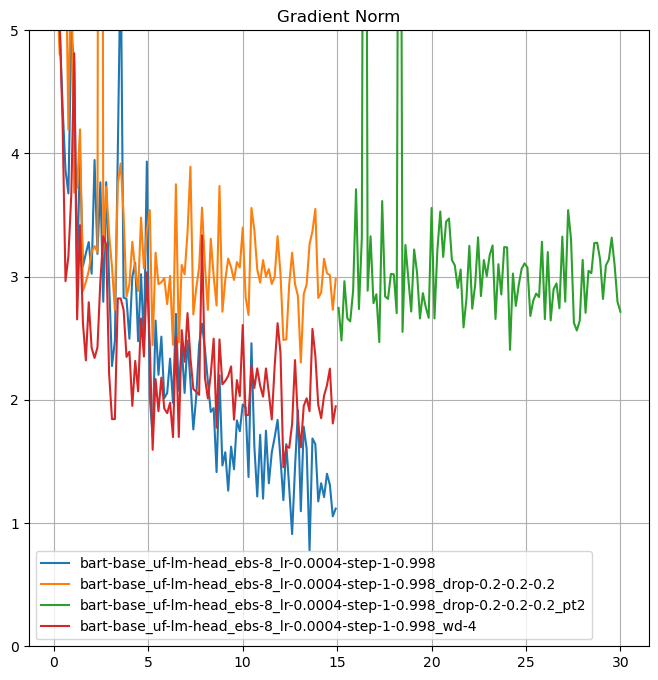

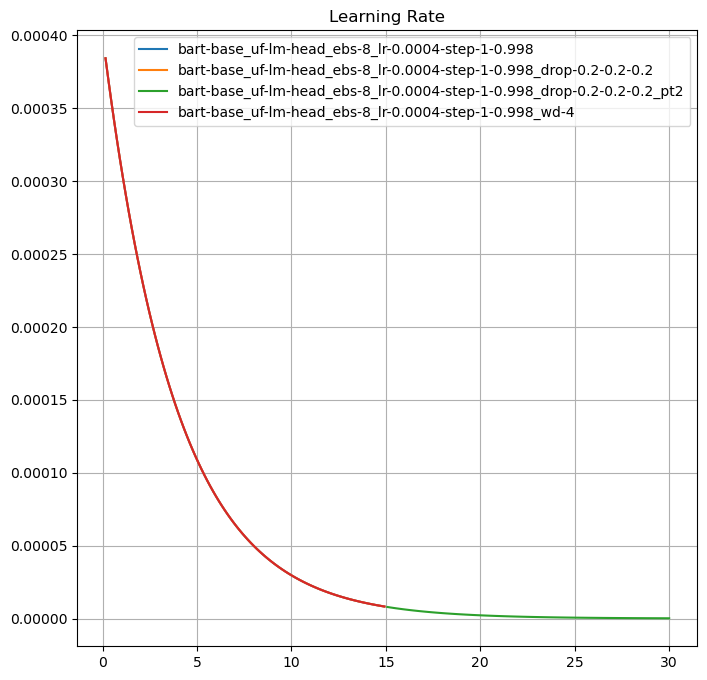

In [16]:
# Regular expression to capture key-value pairs
pattern = re.compile(r"'(\w+)': ([\d.e+-]+)")
fname = './logs/003_bart-base.txt'

fnumbers = list(range(0,4))
fnumbers = [0, 1, 2, 3, 4, 5] # lr experiments
fnumbers = ['5-10', '5-30', '5a-10']
# fnumbers = ['5-30']
# fnumbers = ['5a-10']

"""
LoRA r, 5 epochs
r = 2, 8, 16, 32
alpha = 32
"""
fnumbers = [5]
fnumbers2 = [23, 25, 26]

"""
LoRA r, 5 epochs
r = 2, 8, 16, 32
alpha = 32
"""
fnumbers = [5]
fnumbers2 = [23, 25, 26]

"""
LoRA alpha, 5 epochs
r = 8
alpha = 32, 64
"""
fnumbers = [5]
fnumbers2 = [36]

""" LoRA alpha = 128 """
fnumbers = [5]
fnumbers2 = [46, 47]

""" Weight decay """
fnumbers = ['5-30', '5a-10']
fnumbers2 = [69.1, '69.3-30c', '69.6-30c']

""" Sanity-check the original train-val split """
# fnumbers = ['5-30', '5-30-og', '5-30-og-lm']
# fnumbers2 = ['55c', '55c-30-og', '69.3-30c', '69.3-30c-og']

fnumbers = ['5-30', '5-lm-30']
fnumbers2 = ['26-lm-30', '28-lm-30', '28-lm-30a']

fnumbers = ['005-lm-30_bart-base']
fnumbers2 = []

# fnumbers2 = [14, 15]
# fnumbers2 = [26, 36, 46, 47] # LoRA r, alpha experiments
# fnumbers2 = [55, '55a', '55b', '55c', 57] # BART dropout experiments
# fnumbers2 = ['55c', 57]
# fnumbers2 = []
# fnumbers2 = fnumbers2 + [67, 69, 69.1, 69.3, 69.6, '69.6-30', 70] # weight decay experiments
# fnumbers2 = fnumbers2 + [69.3, '69.3-30c', 69.6, '69.6-30c']

# fnames = ['005-lm-30_bart-base']

fnames = ["bart-base_uf-all_ebs-8_lr-0.00005-step-1-0.998",
          "bart-base_uf-all_ebs-8_lr-0.0001-step-1-0.998",
          "bart-base_uf-all_ebs-8_lr-0.0002-step-1-0.998",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998",
         ]

fnames = ["bart-base_lora-8-32-0_ebs-8_lr-0.0004-step-1-0.998",
          "bart-base_lora-8-32-0_ebs-8_lr-0.0008-step-1-0.998",
          "bart-base_lora-8-32-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-8-128-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-128-128-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-512-128-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-512-128-0_ebs-8_lr-0.0008-step-1-0.998",
          "bart-base_lora-512-128-0_ebs-8_lr-0.0032-step-1-0.998",
         ]

fnames = ["bart-base_lora-128-128-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-512-128-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.998",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999_pt2",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.9992",
         ]

fnames = ["bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_ogtvsplit",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0016-step-1-0.998",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999_pt2",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.9992",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.9994",
         ]

fnames = ["bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_kfold0",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_kfold1",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_kfold2",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_kfold3",
          "bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_kfold4",
         ]

fnames = ["bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999",
          "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999_pt2",
          "bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998",
         ]

# Applying regularization makes both training and validation loss worse
fnames = ["bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998",
          "bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_drop-0.2-0.2-0.2",
          "bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_drop-0.2-0.2-0.2_pt2",
          "bart-base_uf-lm-head_ebs-8_lr-0.0004-step-1-0.998_wd-4",
         ]

def parse_txt_log(fnames, pattern, plot=True):
    if plot:
        fig_tloss = plt.figure(figsize=(8,8))
        fig_vloss = plt.figure(figsize=(8,8))
        fig_grad_norm = plt.figure(figsize=(8,8))
        fig_lr = plt.figure(figsize=(8,8))

    tlossmax = -1
    vlossmax = -1
    all_results = {fname: {} for fname in fnames}
    for fname in fnames:
        losses = []
        grad_norms = []
        learning_rates = []
        epochs = []

        eval_losses = []
        eval_epochs = []
        
        # Read the file and extract values
        with open('./logs/' + fname + ".txt", 'r') as file:
            lines = file.readlines()
        
            for line in lines:
                matches = pattern.findall(line)  # Find all key-value pairs in the line
                data = {key: float(value) for key, value in matches}  # Convert to dictionary
        
                # Append the values to the respective lists
                if 'loss' in data:
                    losses.append(data['loss'])
                    
                    if 'grad_norm' in data:
                        grad_norms.append(data['grad_norm'])
                    else:
                        grad_norms.append(0.0)
        
                    if 'learning_rate' in data:
                        learning_rates.append(data['learning_rate'])
                    else:
                        learning_rates.append(0.0)
                    
                    epochs.append(data['epoch'])
                    
                elif 'eval_loss' in data:
                    eval_losses.append(data['eval_loss'])
                    eval_epochs.append(data['epoch'])

            tlossmax = max(tlossmax, max(losses))
            vlossmax = max(vlossmax, max(eval_losses))

        all_results[fname]['tloss'] = losses
        all_results[fname]['grad_norm'] = grad_norms
        all_results[fname]['lr'] = learning_rates
        all_results[fname]['t_epochs'] = epochs
        all_results[fname]['vloss'] = eval_losses
        all_results[fname]['v_epochs'] = eval_epochs

        if plot:
            plt.figure(fig_tloss.number)
            plt.plot(epochs, losses, label=fname)

            plt.figure(fig_vloss.number)
            plt.plot(eval_epochs, eval_losses, label=fname)
    
            plt.figure(fig_grad_norm.number)
            plt.plot(epochs, grad_norms, label=fname)
    
            plt.figure(fig_lr.number)
            plt.plot(epochs, learning_rates, label=fname)

    if plot:
        plt.figure(fig_tloss.number)
        plt.title('Training Loss')
        plt.ylim([0, tlossmax])
        plt.legend()
        plt.grid()

        plt.figure(fig_vloss.number)
        plt.title('Eval Loss')
        plt.ylim([0, vlossmax])
        plt.legend()
        plt.grid()

        plt.figure(fig_grad_norm.number)
        plt.title('Gradient Norm')
        plt.ylim([0, 5])
        plt.legend()
        plt.grid()

        plt.figure(fig_lr.number)
        plt.title('Learning Rate')
        plt.legend()
        plt.grid()

    return all_results
        

all_results = parse_txt_log(fnames, pattern)

In [17]:
del trainer
del model
torch.cuda.empty_cache()
gc.collect()

15369

# Inference

In [10]:
if not os.path.exists("predictions"):
    os.mkdir("predictions")
    print("Created new directory ./predictions")

In [12]:
save_predictions = False


"""Load trained base model"""
model_type = "base"
# model_dir = r"output\bart-base_uf-all_ebs-8_lr-0.0001-step-1-0.998\checkpoint-1950"
# model_dir = r"output\bart-base_uf-all_ebs-8_lr-0.0002-step-1-0.998\checkpoint-1950"
model_dir = r"output\bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998\checkpoint-1950"
# model_dir = r"output\bart-base_uf-all_ebs-8_lr-0.0004-step-1-0.998_ogtvsplit\checkpoint-2250"

"""Base model frozen; load trained LoRA weights only"""
# model_type = "lora-only"
# model_dir = r"output\bart-base_lora-8-32-0_ebs-8_lr-0.0004-step-1-0.998\checkpoint-1950"
# model_dir = r"output\bart-base_lora-128-128-0_ebs-8_lr-0.0016-step-1-0.998\checkpoint-1950"
# model_dir = r"output\bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999\checkpoint-1950"
# model_dir = r"output\bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999_pt2\checkpoint-3900"

if save_predictions:
    base_name = "bart-base_lora-512-512-0_ebs-8_lr-0.0008-step-1-0.999_pt2_checkpoint-3900"
    fname = os.path.join("predictions", base_name + "_metrics.txt") # metrics

if model_type == "base":
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
elif model_type == "lora-only":
    model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')
    # model = PeftModel.from_pretrained(base_model, model_dir)
    model.load_adapter(model_dir)
    
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base', truncation_side='left')
# model.config.pad_token_id = model.config.eos_token_id

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

gen_cfg = GenerationConfig(
    max_length=500,
    decoder_start_token_id=model.config.decoder_start_token_id,
    bos_token_id=model.config.bos_token_id,
    eos_token_id=model.config.eos_token_id,
)

training_args = Seq2SeqTrainingArguments(
    disable_tqdm=True,  # disable progress bar
    output_dir=output_dir,
    save_strategy='no',
    logging_strategy='no',

    per_device_train_batch_size=train_batch_size, # batch size per device (CPU core/GPU/etc.)
    per_device_eval_batch_size=eval_batch_size, # batch size per device (CPU core/GPU/etc.)

    # Training hyperparameters
    num_train_epochs=num_epochs, # max epochs
    gradient_accumulation_steps=grad_accum,
    # learning_rate=5e-8, # default is 5e-5
    # learning_rate=3e-5, # FYI: the default linear scheduler updates learning rate per batch
    learning_rate=learning_rate,
    # warmup_ratio=0.2, # 20% of training steps
    # max_grad_norm=1.0,
    weight_decay=weight_decay,

    # Seq2Seq
    predict_with_generate=True,
    # generation_max_length=500,
    #generation_num_beams=4,
    generation_config=gen_cfg,

    # Random
    seed=42,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    # train_dataset=ds_train,
    # eval_dataset=ds_eval,
    tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
    data_collator=data_collator, # dynamic padding
    compute_metrics=valmet.compute_metrics,
)

print("Finished loading model")

Finished loading model


In [71]:
sample = preprocessor.tokenized_dataset['train'][np.nonzero(np.array(preprocessor.tokenized_dataset['train']['ID']) == 727)[0].item()]
sample = {key: [value] for key,value in sample.items()}
sample2 = preprocessor.tokenized_dataset['val'][np.nonzero(np.array(preprocessor.tokenized_dataset['val']['ID']) == 209)[0].item()]
sample3 = preprocessor.tokenized_dataset['val'][np.nonzero(np.array(preprocessor.tokenized_dataset['val']['ID']) == 649)[0].item()]
for key in sample:
    sample[key].append(sample2[key])
    sample[key].append(sample3[key])
# sample = {key: [value] for key, value in sample.items()}
sample = datasets.Dataset.from_dict(sample)
# sample.pop('length')
# sample.pop('labels')
# sample.pop('ID')
# sample.pop('section_header')
# print(sample.keys())

In [72]:
sample

Dataset({
    features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
    num_rows: 3
})

In [73]:
data_split = 'train'
# data_split = 'val'
# data_split = 'test'

# ds_pred = preprocessor.tokenized_dataset[data_split]
# ds_pred = preprocessor.tokenized_dataset[data_split].select(range(10))
ds_pred = sample
predictions = trainer.predict(ds_pred)
print("Finished predictions")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Finished predictions


In [74]:
# Save predicted tokens (2D numpy array of size num_samples*max_seq_len)

decoder_output_ids = predictions.predictions
decoder_output_ids[decoder_output_ids == -100] = tokenizer.pad_token_id

if save_predictions:
    fname2 = os.path.join("predictions", base_name + "_" + data_split + ".npy") # decoder output IDs
    np.save(fname2, decoder_output_ids)
    print(f"Saved decoder output IDs to {fname2}")

In [75]:
# decoder_output_ids = np.load(fname2)
decoder_output_ids = decoder_output_ids[:10,:]
decoded_output = tokenizer.batch_decode(decoder_output_ids, skip_special_tokens=True)
for odx, out in enumerate(decoded_output):
    print(f'ID: {ds_pred[odx]['ID']}')
    print('Dialogue:\n')
    print(ds_pred[odx]['dialogue'])
    print('')
    print('Ground truth:\n')
    print(ds_pred[odx]['section_text'])
    print('')
    print('Prediction:\n')
    print(out)
    print('')
    print('*******************************************************************')

ID: 727
Dialogue:

Doctor: Remind me, how did he hurt himself?
Guest_family_1: He was riding quads on October tenth two thousand seven when he got thrown off. 
Doctor: Yes, and we did O R I F on his fracture dislocation of the left elbow. 
Guest_family_1: Yes, he also fractured the neck of his right glenoid, um, if I remember correctly. 
Doctor: Which hand does he write with? 
Guest_family_1: He writes with his right hand. 
Doctor: Okay. That fracture appears to have healed very well; kids generally heal pretty well. How does it feel today? 
Guest_family_1: Yes, he's only ten. He's been pretty stiff, so he's been going to P T, and using his Dynasplint.
Doctor: That's good that he is already in P T. His left elbow fracture is healed, so we should do another surgery in order to remove that hardware. That may help decrease some of the irritation with elbow extension. He looks neurologically intact in terms of movement and reflexed in his wrist and hand. 
Guest_family_1: Yes, I agree. What

In [70]:
# Save metrics. I think you should have plots for each metric. x axis will be train/val/split, and y-axis will be the metric value. So each call to plot will be for one model, 3 data points.

pattern = re.compile(r"(test_|eval_)")
pattern_ignore = re.compile(r"(runtime|samples_per_second|steps_per_second)")

metrics = {data_split + "_" + pattern.sub("", key): value for key, value in predictions.metrics.items() if not(pattern_ignore.search(key))}
print(metrics)
metrics_str = json.dumps(metrics, indent=0)

if save_predictions:
    if not os.path.exists(fname):
        print(f"Creating file {fname}")
        with open(fname, "w") as file:
            file.write(metrics_str)
            print(f"File saved: {fname}")
    else:
        print(f"Opening file {fname} in append mode")
        with open(fname, "a") as file:
            file.write(metrics_str)
            print(f"File saved: {fname}")

{'train_loss': 0.6967151165008545, 'train_bertscore_precision': 0.9380790591239929, 'train_bertscore_recall': 0.9473483562469482, 'train_bertscore_f1': 0.9426651895046234, 'train_rouge1': 0.773972602739726, 'train_rouge2': 0.6805555555555556, 'train_rougeL': 0.7054794520547946, 'train_rougeLsum': 0.7602739726027397}


In [74]:
del trainer, model
torch.cuda.empty_cache()
gc.collect()

117

In [ ]:
sample = {}
sample['input_ids'] = ds_train[0]['input_ids'].unsqueeze(dim=0)
sample['attention_mask'] = ds_train[0]['attention_mask'].unsqueeze(dim=0)
sample['labels'] = ds_train[0]['labels'].unsqueeze(dim=0)

In [ ]:
model.to('cpu')
# output = model.generate(**sample, num_beams=4, max_length=150, early_stopping=True)
output = model.generate(**sample, max_new_tokens=200)
decoded = tokenizer.decode(output[0], skip_special_tokens=True)

print('Dialogue:\n')
print(ds_train['dialogue'][0] + '\n')
print('Ground truth:\n')
print(ds_train['section_text'][0] + '\n')
print('Prediction:\n')
print(decoded)

In [ ]:
# Baseline

model_base = AutoModelForSeq2SeqLM.from_pretrained(model_name)
output = model_base.generate(**sample, num_beams=4, max_length=150, early_stopping=True)
decoded_base = tokenizer.decode(output[0], skip_special_tokens=True)

print('Dialogue:\n')
print(ds_train['dialogue'][0] + '\n')
print('Ground truth:\n')
print(ds_train['section_text'][0] + '\n')
print('Prediction:\n')
print(decoded_base)

# Evaluation

In [ ]:
# nli = pipeline("text-classification", model="FacebookAI/roberta-large-mnli")
bertscore = evaluate.load('bertscore')

In [ ]:
r = ds_train['section_text'][0]
p = decoded

In [ ]:
print(f"{r} </s> {p}")
results = nli(f"{r} </s> {p}", truncation=True, top_k=None)
results

In [ ]:
del nli

In [ ]:
results = bertscore.compute(predictions=[p], references=[r], model_type='bert-base-uncased')
results

In [ ]:
p = decoded_base
results = bertscore.compute(predictions=[p], references=[r], model_type='bert-base-uncased')
results

In [ ]:
# del bertscore

# Early Notes
* This is the question you should ask yourself before anything else: what do I want the model to do, and why? Once I figure that out, is there a model out there that already does it? If not, that's when you start thinking about fine-tuning.
* Flexible model: instruction tuning, e.g. "Summarize this into one sentence, summarize this dialogue, etc."
* google/pegasus-xsum and facebook/bart-large-xsum are already pretty good for single-sentence summaries
* facebook/bart-large-cnn and google/pegasus-large - I'm assuming these are pretty good for summaries in general
* You could try to find a dataset that these models don't work well on: https://huggingface.co/datasets/argilla/FinePersonas-Conversations-Email-Summaries?row=18
* Dialog summarization: https://huggingface.co/datasets/knkarthick/dialogsum?row=0
* Question to answer: even the fine-tuned model doesn't summarize the document in one sentence. So what exactly is the objective of my fine-tuning? Remember, I want to change the behavior of my model.
    * **Is it to shorten the summary to one sentence? This might be useful. You could see if you can apply the length objective function.**
    * Is it to summarize in a specific format? Can I find a dataset in that format? Or do I have to spend money to get GPT to do it for me?
    * Is it to get better entailment? For this, I'd need to feed in the original document as the reference, and I don't even know if my entailment model could handle that size.
    * Personally I think bart-large-cnn does a better job of summarization than distilbart-cnn-12-6 (one sample). Is there some way to measure this?
    * I'm not even sure the dataset summary is particularly good (one sample)

# Old Stuff

In [ ]:
print(type(preprocessor.dataloader)) # dictionary. Contains 'train', 'val', 'test'.
print(type(preprocessor.dataloader['train'])) # dataloader


first_batch = next(iter(preprocessor.dataloader['train']))
print(type(first_batch)) # dictionary
print(first_batch.keys())
print(type(first_batch['input_ids']))
print(first_batch['input_ids'].shape)
print(type(first_batch['attention_mask']))
print(first_batch['attention_mask'].shape)
print(type(first_batch['labels']))
print(first_batch['labels'].shape)

In [ ]:
# Example code from https://huggingface.co/docs/datasets/en/use_with_pytorch


import numpy as np
from datasets import Dataset
from torch.utils.data import DataLoader

# Data and labels are scalars, so when you batch with size 4, each batch consists of tensors of length 4
# data = np.random.rand(16)
# label = np.random.randint(0, 2, size=16)


# Modify data and label to be vectors of length 7 (16 total samples)
# Now, when I batch with size 4, each batch consists of 4 tensors (samples) of length 7. So it's working correctly.
data = np.random.rand(16,7)
label = np.random.randint(0, 2, size=(16,7))
ds = Dataset.from_dict({"data": data, "label": label}).with_format("torch")
dataloader = DataLoader(ds, batch_size=4)
for batch in dataloader:
    print(batch)

In [ ]:
label = np.random.randint(0, 2, size=(16,7))
label = np.ones((16,7))

In [ ]:
label.shape

In [ ]:
np.nonzero(label)

In [ ]:
def compute_metrics(eval_pred):
    # Define something here
    return {'my_custom_metric': None}

In [ ]:
training_args = TrainingArguments(
    # Save model checkpoints. # For logging and saving model checkpoints, each 'step' refers to one update of the model's weights.
    # By default, this is once per batch of data, but this isn't necessarily true with gradient accumulation.
    # Typically, we only run validation once per epoch, so there's not much benefit to saving checkpoints more than once per epoch.
    # The only time it's beneficial is if your code is prone to crashing - saving more often means you lose less progress when this happens.
    output_dir='./train_results',
    save_strategy='epoch', # save model checkpoints at the end of each epoch
    eval_strategy='epoch',  # run validation at the end of each epoch

    # Loading the best model state based on the desired metric
    load_best_model_at_end=True,  # load the best model found during training
    # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
    metric_for_best_model='my_custom_metric', # this needs to match a key in the returned dictionary from compute_metrics()
    greater_is_better=True, # higher value for 'my_custom_metric' is better

    # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
    logging_dir='./train_logs',
    logging_strategy='steps',
    logging_steps=100, # frequency of logging - you need to consider your dataset size and your batch size/gradient accumulation

    per_device_train_batch_size=8, # batch size per device (CPU core/GPU/etc.)
    per_device_eval_batch_size=8, # batch size per device (CPU core/GPU/etc.)

    # Training hyperparameters
    num_train_epochs=10, # max epochs
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # This is the validation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 epochs without improvement
    compute_metrics=compute_metrics,  # custom function to compute validation metrics
)

trainer.train()